In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import scipy.sparse as sps
import scipy.io as sio
import os
import sys
import math
from os.path import join

In [2]:
# sys.path.insert(0, '../..')
from ACE.ace import ACE

### loading data

In [3]:
# Path to the data directory
# root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'
data_dir = "../../data/PBMC-Mult"

# print('Reading `mtx` files...')
rna_norm_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'rna_pca.mtx')))         # exported from seurat
atac_norm_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'atac_lsi.mtx')))        # exported from seurat

rna_names = pd.read_csv(join(data_dir, 'gene_names.csv'))['x'].to_numpy()
atac_names = pd.read_csv(join(data_dir, 'atac_names.csv'))['x'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)

train_idx = pd.read_csv(join(data_dir, 'train_idx.csv'))['0'].to_numpy()
test_idx  = pd.read_csv(join(data_dir, 'test_idx.csv'))['0'].to_numpy()

print('Creating `h5ad` files...')
input_train_mod1 = sc.AnnData(sps.csr_matrix(rna_norm_mat[train_idx]), obs=meta_data.loc[cell_names[train_idx]])
input_train_mod2 = sc.AnnData(sps.csr_matrix(atac_norm_mat[train_idx]), obs=meta_data.loc[cell_names[train_idx]])
input_test_mod1 = sc.AnnData(sps.csr_matrix(rna_norm_mat[test_idx]), obs=meta_data.loc[cell_names[test_idx]])
input_test_mod2 = sc.AnnData(sps.csr_matrix(atac_norm_mat[test_idx]), obs=meta_data.loc[cell_names[test_idx]])

# set var names
# input_train_mod1.var_names = input_test_mod1.var_names = rna_names
# input_train_mod2.var_names = input_test_mod2.var_names = atac_names

# set batch 
input_train_mod1.obs['batch'] = 'batch1'
input_train_mod2.obs['batch'] = 'batch1'
input_test_mod1.obs['batch'] = 'batch1'
input_test_mod2.obs['batch'] = 'batch1'

gex = input_train_mod1
other = input_train_mod2
gex_test = input_test_mod1
other_test = input_test_mod2

Creating `h5ad` files...


### preprocessing

In [4]:
rna_pca     = sps.csr_matrix(sio.mmread(join(data_dir, 'rna_pca.mtx')))         # exported from seurat
atac_lsi    = sps.csr_matrix(sio.mmread(join(data_dir, 'atac_lsi.mtx')))        # exported from seurat

input_train_mod1.obsm['X_pca'] = sps.csr_matrix(rna_pca[train_idx])
input_train_mod2.obsm['X_lsi'] = sps.csr_matrix(atac_lsi[train_idx])
input_test_mod1.obsm['X_pca'] = sps.csr_matrix(rna_pca[test_idx])
input_test_mod2.obsm['X_lsi'] = sps.csr_matrix(atac_lsi[test_idx])

### construct inputs

In [5]:
n_parts = 3
modBatch_dict = {
    'rna': [gex, gex_test, None],
    'atac': [other, None, other_test]
}

useReps_dict = {
    'rna': 'X_pca',
    'atac': 'X_lsi'
}

In [6]:
np.array(list(modBatch_dict.keys()))

array(['rna', 'atac'], dtype='<U4')

### stage1 training and inference

In [7]:
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'atac':[1024, 512]}, # consistent across all experiments
    dropout_rates = {'rna':[0.2, 0.2], 'atac':[0.2, 0.2]},  # consistent across all experiments
    T=math.log(1./T), T_learnable=False, log_dir='../../outputs/case1_PBMC-Mult',
    n_latent1=40, n_latent2=256, seed=1234, 
    num_workers=0  # have to set 0 in jupyter notebook, otherwise reporting: https://github.com/jupyter/nbconvert/issues/1066
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'atac']
batch1: ['rna']
batch2: ['atac']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=3.3820, temp=10.0000, batch0 loss=3.3820, 
Epoch 19, loss=3.2049, temp=10.0000, batch0 loss=3.2049, 
Epoch 29, loss=3.1133, temp=10.0000, batch0 loss=3.1133, 
Epoch 39, loss=3.0162, temp=10.0000, batch0 loss=3.0162, 
Epoch 49, loss=2.9641, temp=10.0000, batch0 loss=2.9641, 
Epoch 59, loss=2.8818, temp=10.0000, batch0 loss=2.8818, 
Epoch 69, loss=2.8354, temp=10.0000, batch0 loss=2.8354, 
Epoch 79, loss=2.7827, temp=10.0000, batch0 loss=2.7827, 
Epoch 89, loss=2.7388, temp=10.0000, batch0 loss=2.7388, 
Epoch 99, loss=2.6984, temp=10.0000, batch0 loss=2.6984, 


In [8]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['rna'], ['atac']]
)
ad_integ

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 13882 × 40
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_annotations', 'batch', 'raw_batch', 'domain'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


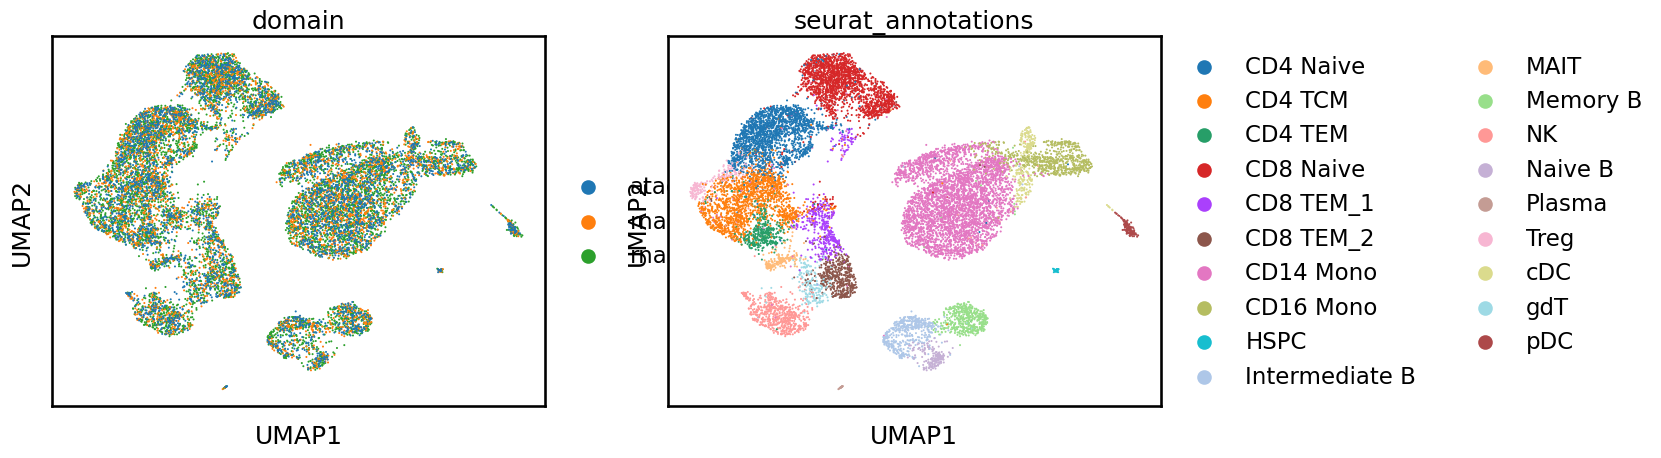

In [9]:
sc.pp.neighbors(ad_integ, n_neighbors=15, use_rep='X')
sc.tl.umap(ad_integ)

sc.pl.umap(ad_integ, color=['domain', 'seurat_annotations'])

### stage2 training and inference

In [10]:
model.stage2_fit(
    batch_size=512,
    epochs=10,
    lr=1.75e-4, 
    log_step=5, 
    obvious_be=True
)

Training stage2
Epoch 0, rna-loss=0.1044, atac-loss=0.0634, 
Epoch 4, rna-loss=0.0325, atac-loss=0.0307, 
Epoch 9, rna-loss=0.0311, atac-loss=0.0303, 


In [11]:
ad_integ2 = model.stage2_infer(
    modBatch_dict, useReps_dict, output_key1='stage1_emb', output_key2='stage2_emb', 
    knn=2, mod_weights={'rna':0.5, 'atac':0.5}
)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


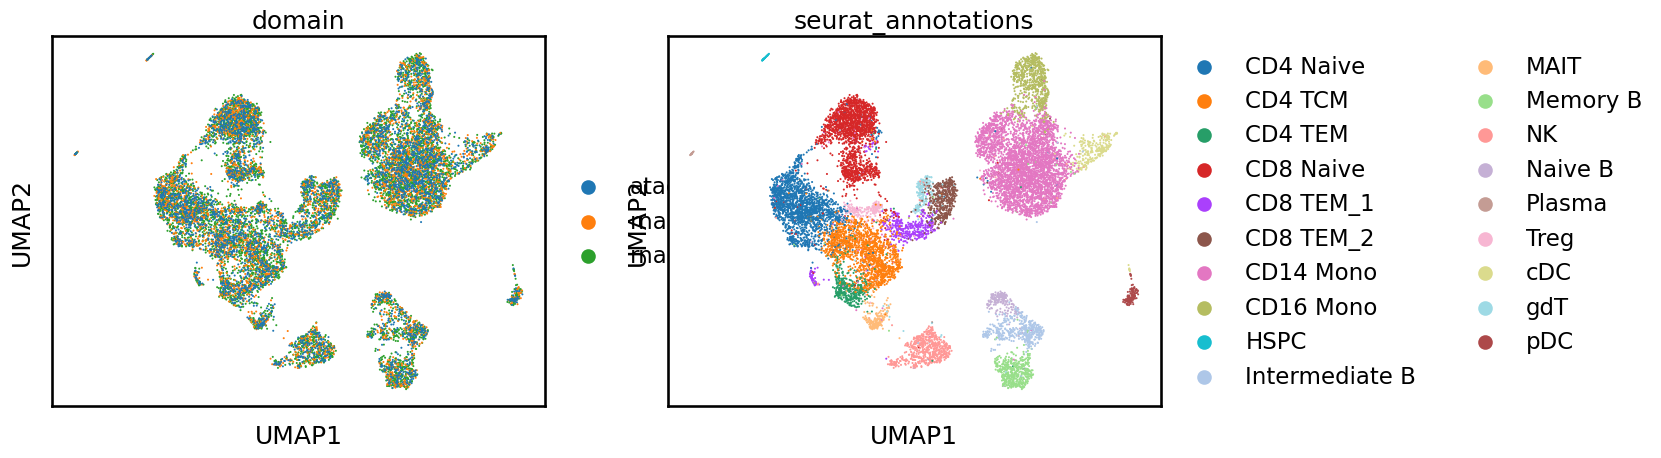

In [12]:
sc.pp.neighbors(ad_integ2, n_neighbors=15, use_rep='X')
sc.tl.umap(ad_integ2)

sc.pl.umap(ad_integ2, color=['domain', 'seurat_annotations'])

## evaluation

In [13]:
from ACE.evaluation import eval_clustering, eval_lisi, eval_bridge, eval_bridge_above2

#### nmi, ari

In [14]:
ad_integ.obsm['stage1_emb'] = ad_integ.X.copy()
ad_integ2.obsm['final_emb'] = ad_integ2.X.copy()

nmi1, ari1 = eval_clustering(
    ad_integ, label_key='seurat_annotations', cluster_key='cluster', resolutions=None, use_rep='stage1_emb',
    use='nmi', nmi_method='arithmetic')

nmi2, ari2 = eval_clustering(
    ad_integ2, label_key='seurat_annotations', cluster_key='cluster', resolutions=None, use_rep='final_emb',
    use='nmi', nmi_method='arithmetic')

print('stage 1: nmi={:.4f}, ari={:.4f}'.format(nmi1, ari1))
print('stage 2: nmi={:.4f}, ari={:.4f}'.format(nmi2, ari2))

stage 1: nmi=0.8002, ari=0.8036
stage 2: nmi=0.8162, ari=0.8148


#### domain(modal)-lisi, batch-lisi

In [15]:
df_lisi1 = eval_lisi(
        ad_integ,
        batch_keys=['domain'],
        use_rep='stage1_emb', use_neighbors=False,
    )

df_lisi2 = eval_lisi(
        ad_integ2,
        batch_keys=['domain'],
        use_rep='final_emb', use_neighbors=False,
    )

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Chunk 287 does not have enough neighbors. Skipping...
Chunk 375 does not have enough neighbors. Skipping...
Chunk 609 does not have enough neighbors. Skipping...
Chunk 912 does not have enough neighbors. Skipping...
Chunk 1008 does not have enough neighbors. Skipping...
Chunk 1221 does not have enough neighbors. Skipping...
Chunk 2210 does not have enough neighbors. Skipping...
Chunk 2231 does not have enough neighbors. Skipping...
Chunk 2434 does not have enough neighbors. Skipping...
Chunk 2889 does not have enough neighbors. Skipping...
Chunk 3227 does not have enough neighbors. Skipping...
Chunk 3397 does not have enough neighbors. Skipping...
Chunk 3451 does not have enough neighbors. Skipping...
Chunk 3509 does not have enough neighbors. Skipping...
Chunk 3552 does not have enough neighbors. Skipping...
Chunk 3646 does not have enough neighbors. Skipping...
Chunk 3688 does not have enough neighbors. Skipping...
Chunk 3745 does not have enough neighbors. Skipping...
Chunk 3888 doe

In [16]:
print('stage 1: domain(batch)-lisi={:.4f}'.format(df_lisi1.domain_LISI[0]))
print('stage 2: domain(batch)-lisi={:.4f}'.format(df_lisi2.domain_LISI[0]))

stage 1: domain(batch)-lisi=0.7275
stage 2: domain(batch)-lisi=0.8173


#### modality alignment scores

In [17]:
bridge_dict = eval_bridge(
        modBatch_dict['rna'][1], modBatch_dict['atac'][2],
        label_key='seurat_annotations',
        batch_key='batch',
        use_rep='stage1_emb',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.00872
Match_score=0.16346
